In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet("../data/interim/data_10min.parquet")

In [14]:
df.head()

,p (mbar),T (degC),Tdew (degC),rh (%),VPact (mbar),VPdef (mbar),wv (m/s),max. wv (m/s),wd (deg),p (mbar)_filled,T (degC)_filled,Tdew (degC)_filled,rh (%)_filled,VPact (mbar)_filled,VPdef (mbar)_filled
Date Time,,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,-8.90,93.3,3.11,0.22,1.03,1.75,152.3,False,False,False,False,False,False
2009-01-01 00:20:00,996.57,-8.41,-9.28,93.4,3.02,0.21,0.72,1.50,136.1,False,False,False,False,False,False
2009-01-01 00:30:00,996.53,-8.51,-9.31,93.9,3.01,0.20,0.19,0.63,171.6,False,False,False,False,False,False
2009-01-01 00:40:00,996.51,-8.31,-9.07,94.2,3.07,0.19,0.34,0.50,198.0,False,False,False,False,False,False
2009-01-01 00:50:00,996.51,-8.27,-9.04,94.1,3.08,0.19,0.32,0.63,214.3,False,False,False,False,False,False


In [24]:
is_monotonic = df.index.is_monotonic_increasing

delta = df.index.to_series().diff()
interval_count = delta.value_counts().sort_index()
print(f'monotonic status: {is_monotonic}')
print(f'time gap:\n{interval_count}')

monotonic status: True
time gap:
Date Time
0 days 00:10:00    420767
Name: count, dtype: int64


In [26]:
df.describe()

,p (mbar),T (degC),Tdew (degC),rh (%),VPact (mbar),VPdef (mbar),wv (m/s),max. wv (m/s),wd (deg)
count,420234.000000,420234.000000,420234.000000,420234.000000,420234.000000,420234.000000,420224.000000,420224.000000,420224.000000
mean,989.214078,9.442535,4.953603,76.028806,9.532417,4.036216,2.129972,3.530998,174.748064
std,8.360864,8.421086,6.731169,16.460387,4.184016,4.891240,1.544301,2.338056,86.685323
min,913.600000,-23.010000,-25.010000,12.950000,0.790000,0.000000,0.000000,0.000000,0.000000
25%,984.200000,3.360000,0.230000,65.240000,6.210000,0.870000,0.990000,1.760000,124.900000
50%,989.580000,9.410000,5.220000,79.300000,8.860000,2.180000,1.760000,2.960000,198.100000
75%,994.730000,15.460000,10.070000,89.400000,12.350000,5.290000,2.860000,4.730000,234.100000
max,1015.350000,37.280000,23.110000,100.000000,28.320000,46.010000,28.490000,23.500000,360.000000


In [31]:
NaN_col = df.isna().sum()
NaN_col[NaN_col > 0]

p (mbar)         534
T (degC)         534
Tdew (degC)      534
rh (%)           534
VPact (mbar)     534
VPdef (mbar)     534
wv (m/s)         544
max. wv (m/s)    544
wd (deg)         544
dtype: int64

In [36]:
# focus on wind because it is the most volatile variable
wind_null = df["wv (m/s)"].isna()
runs = wind_null.groupby((wind_null.shift()).cumsum()).sum()
runs[runs > 3]

Series([], Name: wv (m/s), dtype: int64)

no long NaN values gaps on this one column. it is safe to continue

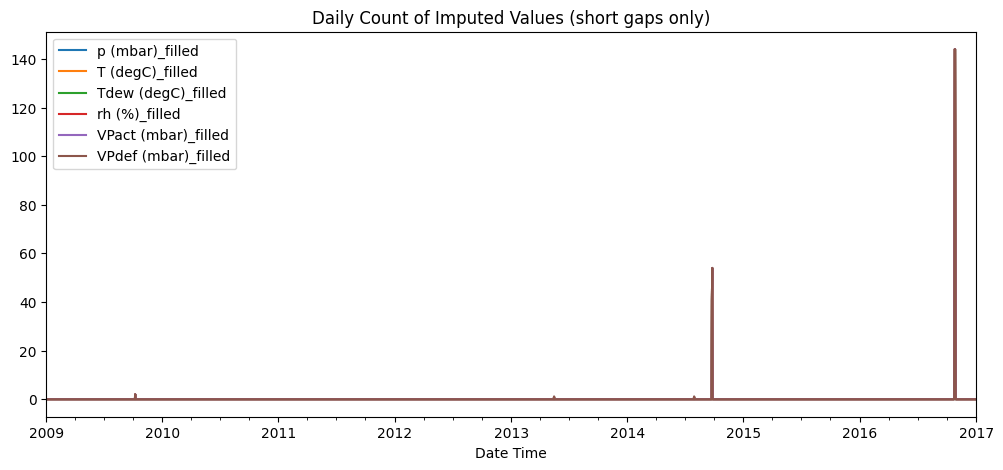

In [39]:
flag_col = [c for c in df.columns if c.endswith("_filled")]

(impute_daily := df[flag_col]
                    .resample('1D')
                    .sum())

impute_daily.plot(figsize=(12,5))
plt.title("Daily Count of Imputed Values (short gaps only)")
plt.show()

In [49]:
flag = df["VPdef (mbar)_filled"]

runs = flag.groupby((flag != flag.shift()).cumsum()).sum()
runs.sort_values(ascending=False).head()

VPdef (mbar)_filled
10    445
8      95
2       2
4       1
6       1
Name: VPdef (mbar)_filled, dtype: int64

we are cut  past 2016 due to this quite high imputation values, 2009 - 2016 is enough range.
i am going to cut this range in the first cleaning phase before resampling 

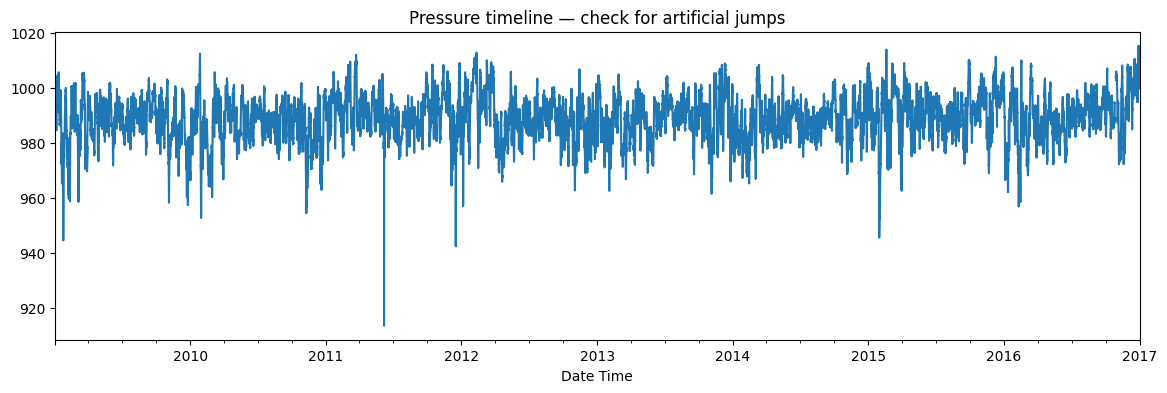

In [ ]:
df["p (mbar)"].plot(figsize=(14,4))
plt.title("Pressure timeline — check for artificial jumps")
plt.show()

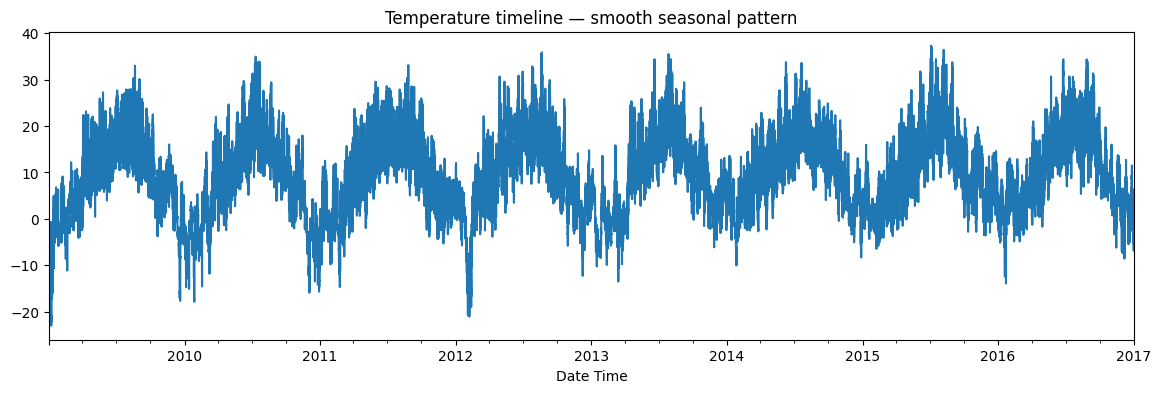

In [42]:
df["T (degC)"].plot(figsize=(14,4))
plt.title("Temperature timeline — smooth seasonal pattern")
plt.show()

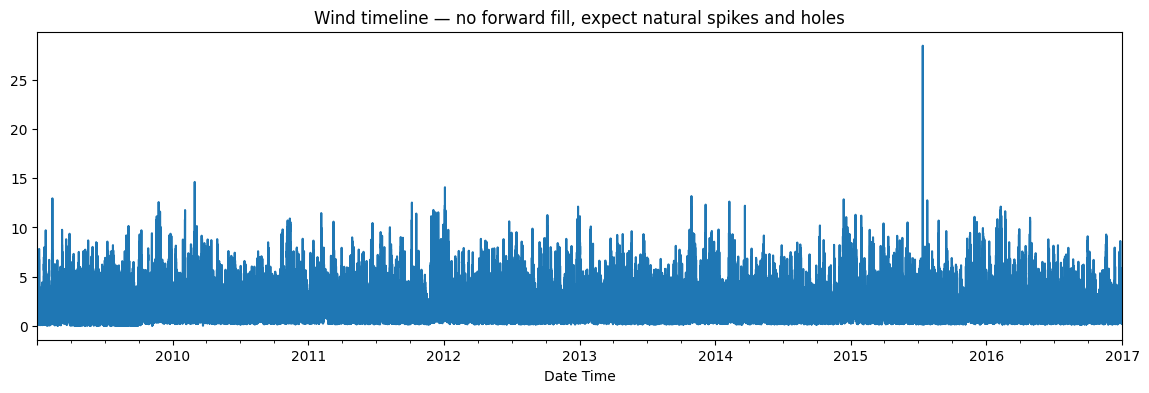

In [43]:
df["wv (m/s)"].plot(figsize=(14,4))
plt.title("Wind timeline — no forward fill, expect natural spikes and holes")
plt.show()


### CONCLUSION

no significant broken structure